### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# import geopandas as gdp
# import keplergl
# from shapely.geometry import Polygon
from folium import plugins
import folium

In [2]:
sns.set_style("whitegrid")

### Import Dataset

In [3]:
df = pd.read_csv("../input/escooters-trips/E-Scooter_Trips_-_2020.csv")
df.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location
0,3eb9a2a3-3266-4559-b1ec-e83a6f7972ab,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,"1,153","1,027",spin,68.0,68.0,ENGLEWOOD,ENGLEWOOD,41.780068,-87.642266,POINT (-87.64226608 41.78006847),41.780068,-87.642266,POINT (-87.64226608 41.78006847)
1,82dd7b8f-8de0-4f25-829b-b32bf47e8419,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,17,91,spin,22.0,21.0,LOGAN SQUARE,AVONDALE,41.922903,-87.704301,POINT (-87.70430082 41.92290349),41.939283,-87.710757,POINT (-87.71075685 41.93928256)
2,9120cbf3-f749-49b6-b894-0e6e065cd731,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,"2,883",724,spin,3.0,6.0,UPTOWN,LAKE VIEW,41.965435,-87.655145,POINT (-87.65514456 41.96543532),41.943514,-87.657498,POINT (-87.65749768 41.9435138)
3,cf2e4abc-2649-49be-924b-468a1aefc4c8,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,5,21,spin,31.0,31.0,LOWER WEST SIDE,LOWER WEST SIDE,41.848335,-87.675179,POINT (-87.67517932 41.84833501),41.848335,-87.675179,POINT (-87.67517932 41.84833501)
4,0448afb5-ab64-4090-b528-e3050e7eb0f2,08/12/2020 07:00:00 AM,08/12/2020 07:00:00 AM,"1,179",245,spin,6.0,6.0,LAKE VIEW,LAKE VIEW,41.943514,-87.657498,POINT (-87.65749768 41.9435138),41.943514,-87.657498,POINT (-87.65749768 41.9435138)


**Data Information**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630816 entries, 0 to 630815
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip ID                      630816 non-null  object 
 1   Start Time                   630816 non-null  object 
 2   End Time                     630816 non-null  object 
 3   Trip Distance                630816 non-null  object 
 4   Trip Duration                630816 non-null  object 
 5   Vendor                       630816 non-null  object 
 6   Start Community Area Number  629934 non-null  float64
 7   End Community Area Number    629598 non-null  float64
 8   Start Community Area Name    629934 non-null  object 
 9   End Community Area Name      629598 non-null  object 
 10  Start Centroid Latitude      629934 non-null  float64
 11  Start Centroid Longitude     629934 non-null  float64
 12  Start Centroid Location      629934 non-null  object 
 13 

**Data Preprocessing**

We create the following rules:
A trip needs to last at least one minute.
The length of a trip needs to be at least 100 meters."

In [5]:
# Remove Comma from Values
df["Trip Duration"] = df["Trip Duration"].str.replace(",", "")
# Convert Data Type to Int
df["Trip Duration"] = df["Trip Duration"].astype("int")

# Remove Comma from Values
df["Trip Distance"] = df["Trip Distance"].str.replace(",", "")
# Convert Data Type to Int
df["Trip Distance"] = df["Trip Distance"].astype("int")

In [6]:
# Dropping rows where distance is less than 150 meters or time is less than 90 seconds
df = df.drop(df[(df['Trip Distance'] < 150) | (df['Trip Duration'] < 90)].index)

In [7]:
# Table shape after removing rows with respect to conditions
df.shape

(547220, 16)

In [8]:
# Convert Start Time Data Type to Datetime 
df['Start Time'] = pd.to_datetime(df['Start Time'])

# Extract Date from Start Time Column
df['Start Date'] = pd.to_datetime(df['Start Time']).dt.date

df['Start Date'] = pd.to_datetime(df['Start Date'])

### Number of Trips by Date

In [9]:
ntd = df.groupby("Start Date")["Start Date"].agg(["count"]).reset_index()
ntd.columns = ["Date", "Trips"]
ntd.head()

,Date,Trips
0,2020-08-12,2927
1,2020-08-13,3697
2,2020-08-14,4460
3,2020-08-15,5023
4,2020-08-16,5296


In [10]:
# Averae Trips per day
atpd = ntd["Trips"].mean()
atpd

4448.943089430894

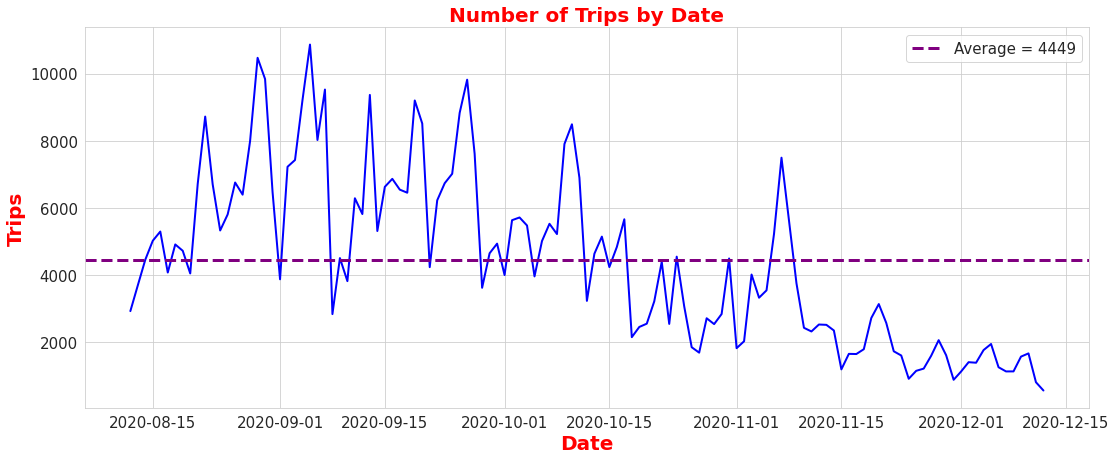

In [11]:
plt.figure(figsize = (18, 7))
plot = sns.lineplot(x = "Date", y = "Trips", data = ntd, color = "blue", linewidth = 2)
plot.axhline(atpd, linestyle="--", color="purple", label="Average = 4449", linewidth = 3) 
plt.title("Number of Trips by Date", size = 20, color = "red", weight = "bold")
plt.xlabel("Date", size = 20, color = "red", weight = "bold")
plt.ylabel("Trips", size = 20, color = "red", weight = "bold")
plt.legend(prop={'size': 15})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

### Number of Trips by Day of Week

In [12]:
# Extract Day Name from Start Date Column
df["Day of Week"] = df["Start Date"].dt.day_name()

In [13]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tdw = df.groupby("Day of Week")["Day of Week"].agg(["count"]).reindex(cats).reset_index()
tdw.columns = ["Day of Week", "Trips"]
tdw

,Day of Week,Trips
0,Monday,61128
1,Tuesday,60091
2,Wednesday,72843
3,Thursday,72408
4,Friday,88764
5,Saturday,105808
6,Sunday,86178


In [14]:
atdw = tdw["Trips"].mean()
atdw

78174.28571428571

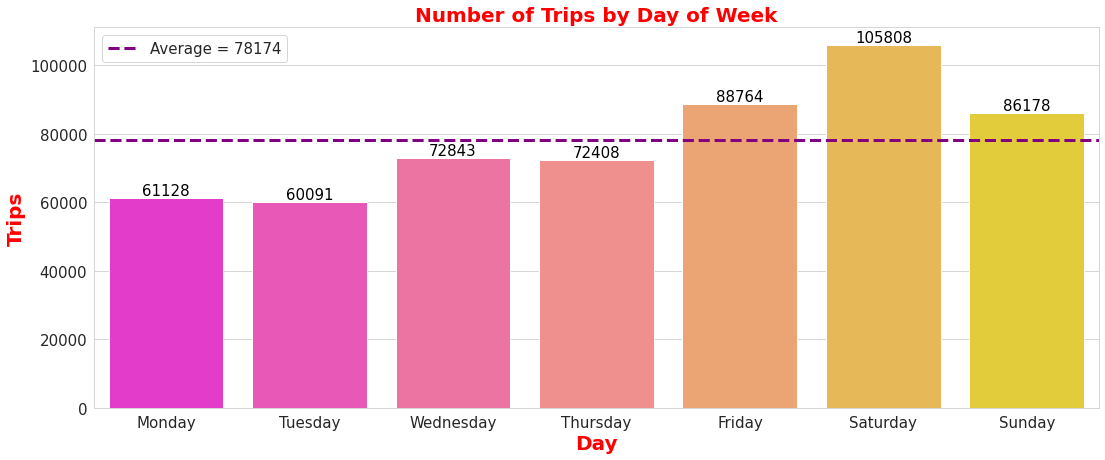

In [15]:
plt.figure(figsize = (18, 7))
plot = sns.barplot(x = "Day of Week", y = "Trips", data = tdw, palette = "spring")
for p in plot.patches:
        plot.annotate('{:.0f}'.format(p.get_height()), 
                      (p.get_x()+0.4, p.get_height()),
                       ha='center', va='bottom',color= 'black', size = 15)
plot.axhline(atdw, linestyle="--", color="purple", label="Average = 78174", linewidth = 3) 
plt.title("Number of Trips by Day of Week", size = 20, color = "red", weight = "bold")
plt.xlabel("Day", size = 20, color = "red", weight = "bold")
plt.ylabel("Trips", size = 20, color = "red", weight = "bold")
plt.legend(prop={'size': 15})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

### Distribution of Trips over Hours of the Day 

In [16]:
df["Hour"] = df["Start Time"].dt.hour

In [17]:
thd = df["Hour"].value_counts().to_frame().reset_index()
thd.columns = ["Hour", "Trips"]
thd

,Hour,Trips
0,17,58587
1,18,58403
2,16,52854
3,19,49838
4,15,47824
5,14,41795
6,20,39606
7,13,37959
8,12,34670
9,21,30926


In [18]:
athd = thd["Trips"].mean()
athd

22800.833333333332

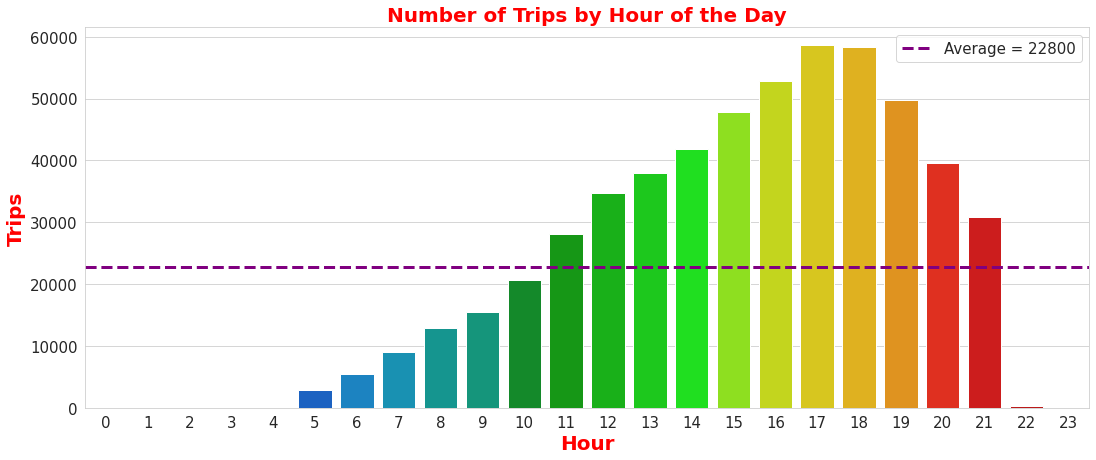

In [19]:
plt.figure(figsize = (18, 7))
plot = sns.barplot(x = "Hour", y = "Trips", data = thd, palette = "nipy_spectral")
plot.axhline(athd, linestyle="--", color="purple", label="Average = 22800", linewidth = 3) 
plt.title("Number of Trips by Hour of the Day", size = 20, color = "red", weight = "bold")
plt.xlabel("Hour", size = 20, color = "red", weight = "bold")
plt.ylabel("Trips", size = 20, color = "red", weight = "bold")
plt.legend(prop={'size': 15})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

### Number of trips by day of week for first and last 15 days

In [20]:
# First 15 Days
ftd = df[(df["Start Date"] >= "2020-08-12") & (df["Start Date"] <= "2020-08-26")]
ftd["Time Period"] = "First 15 Days"

In [21]:
# Last 15 Days
ltd = df[(df["Start Date"] >= "2020-11-12") & (df["Start Date"] <= "2020-11-26")]
ltd["Time Period"] = "Last 15 Days" 

In [22]:
fltd = pd.concat([ftd, ltd])

**Trips Statistics by Time Period**

In [23]:
fl_15 = fltd.groupby("Time Period").agg({"Time Period": "count",
                                                        "Trip Distance": "mean",
                                                        "Trip Duration": "mean"})
fl_15.columns = ["Trips", "Trips Distance", "Trips Duration"]
fl_15 = fl_15.reset_index()
fl_15

,Time Period,Trips,Trips Distance,Trips Duration
0,First 15 Days,79187,3938.061083,1448.776201
1,Last 15 Days,28729,2404.381566,742.904591


In [24]:
fl_15 = fl_15.to_csv("Trips_Statistics_by_Time_Period.csv")

**Trips Statistics by Day of Week and Time Period**

In [25]:
fltdg = fltd.groupby(["Day of Week", "Time Period"]).agg({"Time Period": "count",
                                                          "Trip Distance": "mean",
                                                          "Trip Duration": "mean"})
fltdg.columns = ["Trips", "Trips Distance", "Trips Duration"]
fltdg = fltdg.reset_index()
fltdg

,Day of Week,Time Period,Trips,Trips Distance,Trips Duration
0,Friday,First 15 Days,11176,4001.340104,1451.206514
1,Friday,Last 15 Days,5655,2551.222635,808.118833
2,Monday,First 15 Days,9404,4038.129519,1430.084751
3,Monday,Last 15 Days,3259,2209.149432,636.962258
4,Saturday,First 15 Days,13742,3848.919735,1411.233590
5,Saturday,Last 15 Days,4924,2377.294070,756.240861
6,Sunday,First 15 Days,11997,4013.857964,1492.836376
7,Sunday,Last 15 Days,2923,2303.794389,761.873418
8,Thursday,First 15 Days,7745,4001.970562,1563.824403
9,Thursday,Last 15 Days,6465,2585.311214,783.619180


In [26]:
fltdg.to_csv("Trips_Statistics_by_Day_of_Week_and_Time_Period.csv")

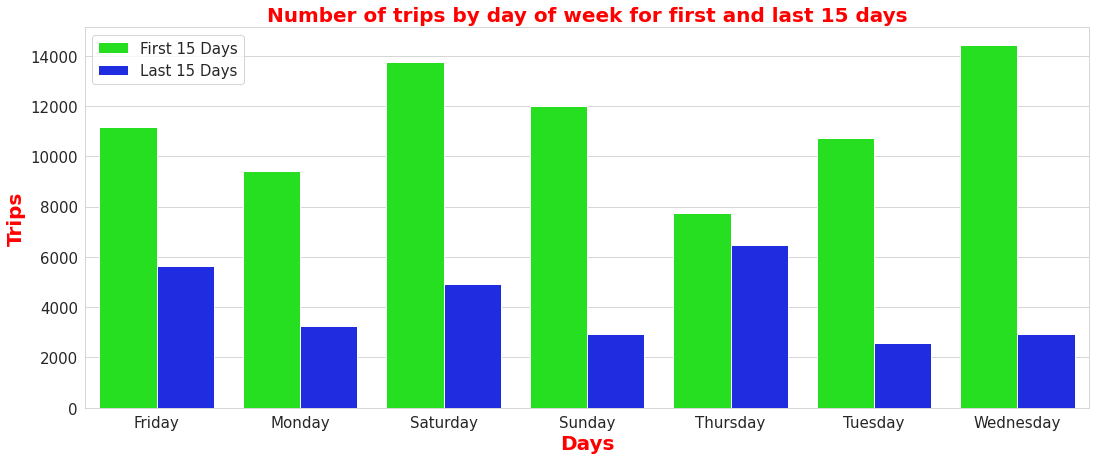

In [27]:
plt.figure(figsize = (18, 7))
sns.barplot(x = "Day of Week", y = "Trips", hue = "Time Period", data = fltdg, palette = "hsv") 
plt.title("Number of trips by day of week for first and last 15 days", size = 20, color = "red", weight = "bold")
plt.xlabel("Days", size = 20, color = "red", weight = "bold")
plt.ylabel("Trips", size = 20, color = "red", weight = "bold")
plt.legend(prop={'size': 15})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [28]:
fltdh = fltd.groupby(["Hour", "Time Period"])["Time Period"].agg(["count"]).reset_index()
fltdh.columns = ["Hour", "Time Period", "Trips"]
fltdh

,Hour,Time Period,Trips
0,0,First 15 Days,2
1,1,First 15 Days,1
2,2,First 15 Days,5
3,3,First 15 Days,3
4,3,Last 15 Days,3
5,4,First 15 Days,3
6,5,First 15 Days,307
7,5,Last 15 Days,255
8,6,First 15 Days,534
9,6,Last 15 Days,422


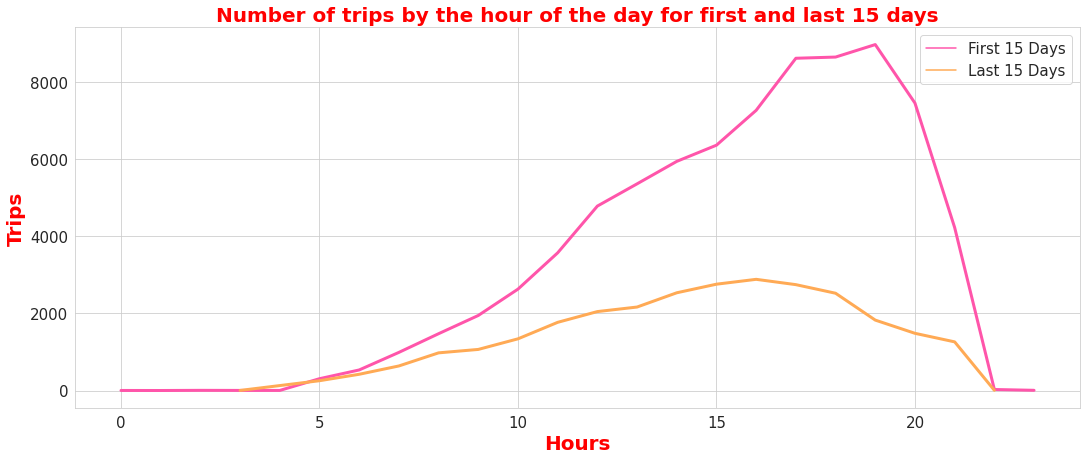

In [29]:
plt.figure(figsize = (18, 7))
sns.lineplot(x = "Hour", y = "Trips", hue = "Time Period", data = fltdh, palette = "spring", linewidth = 3) 
plt.title("Number of trips by the hour of the day for first and last 15 days", size = 20, color = "red", weight = "bold")
plt.xlabel("Hours", size = 20, color = "red", weight = "bold")
plt.ylabel("Trips", size = 20, color = "red", weight = "bold")
plt.legend(prop={'size': 15})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [30]:
df.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,Start Date,Day of Week,Hour
0,3eb9a2a3-3266-4559-b1ec-e83a6f7972ab,2020-08-12 05:00:00,08/12/2020 05:00:00 AM,1153,1027,spin,68.0,68.0,ENGLEWOOD,ENGLEWOOD,41.780068,-87.642266,POINT (-87.64226608 41.78006847),41.780068,-87.642266,POINT (-87.64226608 41.78006847),2020-08-12,Wednesday,5
2,9120cbf3-f749-49b6-b894-0e6e065cd731,2020-08-12 05:00:00,08/12/2020 05:00:00 AM,2883,724,spin,3.0,6.0,UPTOWN,LAKE VIEW,41.965435,-87.655145,POINT (-87.65514456 41.96543532),41.943514,-87.657498,POINT (-87.65749768 41.9435138),2020-08-12,Wednesday,5
4,0448afb5-ab64-4090-b528-e3050e7eb0f2,2020-08-12 07:00:00,08/12/2020 07:00:00 AM,1179,245,spin,6.0,6.0,LAKE VIEW,LAKE VIEW,41.943514,-87.657498,POINT (-87.65749768 41.9435138),41.943514,-87.657498,POINT (-87.65749768 41.9435138),2020-08-12,Wednesday,7
5,5b7425e1-0b21-46d5-9ac1-55f2f1777738,2020-08-12 07:00:00,08/12/2020 07:00:00 AM,3815,840,spin,6.0,3.0,LAKE VIEW,UPTOWN,41.943514,-87.657498,POINT (-87.65749768 41.9435138),41.965435,-87.655145,POINT (-87.65514456 41.96543532),2020-08-12,Wednesday,7
8,a5b7250d-51b9-4504-b849-bb7b04bd81d3,2020-08-12 07:00:00,08/12/2020 07:00:00 AM,4709,1421,spin,7.0,6.0,LINCOLN PARK,LAKE VIEW,41.921880,-87.645647,POINT (-87.64564651 41.92188043),41.943514,-87.657498,POINT (-87.65749768 41.9435138),2020-08-12,Wednesday,7
